# Вебинар 6. Двухуровневые модели рекомендаций


### Зачем 2 уровня?
- Классические модели классификации (lightgbm) зачастую работают лучше, чем рекоммендательные модели (als, lightfm)
- Данных много, предсказаний много (# items * # users) --> с таким объемом lightgbm не справляется
- Но рекомендательные модели справляются!

Отбираем top-N (200) *кандидатов* с помощью простой модели (als) --> переранжируем их сложной моделью (lightgbm)
и выберем top-k (10).

---

### Как отбирать кандидатов?

Вариантов множество. Тут нам поможет *MainRecommender*. Пока в нем реализованы далеко не все возможные способы генерации кандидатов

- Генерируем топ-k кандидатов
- Качество кандидатов измеряем через **recall@k**
- recall@k показывает какую долю из купленных товаров мы смогли выявить (рекомендовать) нашей моделью

----

# Практическая часть

# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

import warnings

warnings.filterwarnings('ignore')

## Read data

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
# выше видим разброс по пользователям и товарам

In [10]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [11]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [12]:
# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (784420, 13) Users: 1915 Items: 4999
val_matcher
Shape: (163261, 12) Users: 1915 Items: 27118
train_ranker
Shape: (163261, 12) Users: 1915 Items: 27118
val_ranker
Shape: (115989, 12) Users: 1915 Items: 24042


In [13]:
# Теперь warm-start по пользователям

# Init/train recommender

In [14]:
recommender = MainRecommender(data_train_matcher)

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [15]:
# Берем тестового юзера 2375

In [16]:
recommender.get_als_recommendations(2375, N=5)

[899624, 5569230, 1044078, 871756, 1106523]

In [17]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [18]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 937292, 1078652, 1002787]

In [19]:
recommender.get_similar_users_recommendation(2375, N=5)

[977559, 1008288, 1133654, 861494, 1097398]

# Eval recall of matching

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [20]:
ACTUAL_COL = 'actual'

In [21]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [22]:
# N = Neighbors
N_PREDICT = 50 

In [23]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))

Wall time: 30 s


In [24]:
result_eval_matcher.head(8)

,user_id,actual,own_rec,sim_item_rec,als_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 10...","[882013, 1124432, 9297615, 5577022, 9527325, 9...","[6533368, 8090541, 883616, 995598, 8293439, 95..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 995598, 923600, 972416, 1084036, 11...","[948650, 5569845, 1097458, 941361, 5591170, 10...","[878996, 930118, 854852, 965267, 1127179, 1026..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[998519, 894360, 7147142, 9338009, 896666, 939...","[917384, 1095998, 1044078, 995478, 1114435, 83...","[1039627, 878290, 962777, 839656, 10285022, 94..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101...","[12808385, 939860, 981660, 7410201, 5577022, 6...","[5569845, 5569374, 1044078, 12301073, 909714, ...","[916122, 981660, 998236, 1070845, 839656, 9452..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1...","[872146, 918046, 9655676, 985622, 1056005, 109...","[1008032, 5591170, 901062, 1122532, 1096290, 7...","[901067, 970866, 1042942, 6463710, 1139782, 99..."
5,13,"[6544236, 822407, 908317, 1056775, 1066289, 11...","[965772, 9488065, 10342382, 6554400, 862070, 1...","[5591170, 1120559, 855350, 9526274, 1132911, 9...","[5569471, 933835, 9707240, 8090513, 5569374, 8..."
6,14,"[917277, 981760, 878234, 925514, 986394, 10220...","[902377, 822161, 874563, 1123106, 8090610, 138...","[5591170, 910673, 897954, 1025611, 12132277, 8...","[910673, 1025611, 836445, 1127758, 1131344, 84..."
7,15,"[996016, 1014509, 1044404, 1087353, 976199, 10...","[823576, 1052975, 1053530, 1071196, 1010051, 1...","[901062, 5591170, 1135476, 871188, 999999, 892...","[1042616, 1082185, 12263857, 863632, 933637, 1..."


In [25]:
%%time
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

Wall time: 0 ns


### Пример оборачивания

In [26]:
# # сырой и простой пример как можно обернуть в функцию
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [27]:
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

In [28]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [29]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [30]:
TOPK_RECALL = 50

In [31]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.061684201353290766),
 ('als_rec', 0.047255448406899284),
 ('sim_item_rec', 0.03036508393134996)]

### Precision@5 of matching

In [32]:
TOPK_PRECISION = 5

In [33]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.18872062663185182),
 ('als_rec', 0.12919060052219217),
 ('sim_item_rec', 0.06360313315926937)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [34]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [35]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [36]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [37]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1097398, 101..."


In [38]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [39]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [40]:
df_match_candidates.head(8)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640
0,2070,928263
0,2070,944588
0,2070,1032703
0,2070,1138596


### Check warm start

In [41]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (95750, 2) Users: 1915 Items: 4437


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [42]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

df_ranker_train['target'].fillna(0, inplace= True)

In [43]:
df_ranker_train.target.value_counts()

0.0    88346
1.0    11053
Name: target, dtype: int64

In [44]:
df_ranker_train.head(9)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0
3,2070,948640,0.0
4,2070,928263,0.0
5,2070,944588,0.0
6,2070,1032703,0.0
7,2070,1138596,0.0
8,2070,1092937,1.0


(!) На каждого юзера 50 item_id-кандидатов

In [45]:
df_ranker_train['target'].mean()

0.11119830179378062

Слайд из [презентации](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) решения 2-ого места X5 Retail Hero

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

## Подготавливаем фичи для обучения модели

In [46]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [47]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [48]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(9)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
5,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
6,2070,1032703,0.0,1087,SEAFOOD-PCKGD,National,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
8,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [49]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [50]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

## Обучение модели ранжирования

In [51]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [52]:
df_ranker_predict = df_ranker_train.copy()

In [53]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [54]:
df_ranker_predict.head(9)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,proba_item_purchase
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.060372
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.015765
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.018241
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.001899
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.267902
5,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.063359
6,2070,1032703,0.0,1087,SEAFOOD-PCKGD,National,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.050861
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.003034
8,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.568124


In [55]:
df_ranker_predict.shape

(99399, 17)

In [56]:
df_ranker_predict.loc[df_ranker_predict['user_id']==2070].sort_values('proba_item_purchase', ascending=False)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,proba_item_purchase
8,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.568124
9,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.568124
33,2070,1099905,1.0,830,GROCERY,National,HISPANIC,MEXICAN SAUCESSALSAPICANTEE,16 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.452985
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.267902
48,2070,970866,0.0,5612,GROCERY,National,SUGARS/SWEETNERS,SWEETENERS,9.7 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.267114
15,2070,1026258,0.0,69,NUTRITION,Private,REFRIGERATED,FLUID MILK,64 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.253258
28,2070,984680,0.0,1420,DRUG GM,National,INFANT FORMULA,INFANT FORMULA SOY BASE,25.7 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.251238
12,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.232163
44,2070,926905,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.232163
38,2070,837865,0.0,781,MEAT-PCKGD,National,BACON,FLAVORED/OTHER,1 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.231412


## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [57]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


## Eval matching on test dataset

In [58]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 6.88 s


In [59]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики
TOPK_PRECISION = 5
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1462140992167092)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [60]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [61]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [62]:
result_eval_ranker['reranked_own_rec']

0       [8293439, 8293439, 8293439, 9655212, 9655212]
1        [900802, 900802, 1098844, 1098844, 12757544]
2         [1122358, 9338009, 902640, 1010051, 990897]
3         [921277, 1018339, 829722, 5577022, 1028238]
4       [12171886, 1056509, 896085, 1029743, 1029743]
                            ...                      
1910      [1056509, 1056509, 995876, 1056267, 865511]
1911      [1135834, 1103513, 1053628, 870515, 951164]
1912      [994223, 849578, 1022066, 1073775, 1076580]
1913      [1060872, 1060872, 919766, 924967, 1096728]
1914    [1065538, 1065538, 1065538, 1013389, 1086061]
Name: reranked_own_rec, Length: 1915, dtype: object

In [63]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('own_rec', 0.1462140992167092)
('reranked_own_rec', 0.1261618798955603)


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

# Домашнее задание

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [64]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head()

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1..."


In [65]:
%%time
N_PREDICT = 50 
result_eval_matcher['own_rec_' + str(N_PREDICT)] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec_' + str(N_PREDICT)] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['sim_user_rec_' + str(N_PREDICT)] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec_' + str(N_PREDICT)] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))
HALF_N_PREDICT = int(N_PREDICT / 2)
result_eval_matcher['own_als_rec_' + str(N_PREDICT)] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=HALF_N_PREDICT) + recommender.get_als_recommendations(x, N=HALF_N_PREDICT))
result_eval_matcher['item_als_rec_' + str(N_PREDICT)] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=HALF_N_PREDICT) + recommender.get_als_recommendations(x, N=HALF_N_PREDICT))
result_eval_matcher['user_als_rec_' + str(N_PREDICT)] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=HALF_N_PREDICT) + recommender.get_als_recommendations(x, N=HALF_N_PREDICT))
result_eval_matcher['own_item_rec_' + str(N_PREDICT)] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=HALF_N_PREDICT) + recommender.get_similar_items_recommendation(x, N=HALF_N_PREDICT))
result_eval_matcher['own_user_rec_' + str(N_PREDICT)] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=HALF_N_PREDICT) + recommender.get_similar_users_recommendation(x, N=HALF_N_PREDICT))
result_eval_matcher['item_user_rec_' + str(N_PREDICT)] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=HALF_N_PREDICT) + recommender.get_similar_users_recommendation(x, N=HALF_N_PREDICT))   

Wall time: 16min 18s


In [66]:
result_eval_matcher.head()

,user_id,actual,own_rec_50,sim_item_rec_50,sim_user_rec_50,als_rec_50,own_als_rec_50,item_als_rec_50,user_als_rec_50,own_item_rec_50,own_user_rec_50,item_user_rec_50
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 10...","[882013, 1124432, 9297615, 5577022, 9527325, 9...","[7410321, 1108776, 1057168, 1110624, 942565, 1...","[6533368, 8090541, 883616, 995598, 8293439, 95...","[856942, 9297615, 5577022, 877391, 9655212, 10...","[882013, 1124432, 9297615, 5577022, 9527325, 9...","[7410321, 1108776, 1057168, 1110624, 942565, 1...","[856942, 9297615, 5577022, 877391, 9655212, 10...","[856942, 9297615, 5577022, 877391, 9655212, 10...","[882013, 1124432, 9297615, 5577022, 9527325, 9..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 995598, 923600, 972416, 1084036, 11...","[948650, 5569845, 1097458, 941361, 5591170, 10...","[867138, 970160, 1113675, 970160, 970160, 1226...","[878996, 930118, 854852, 965267, 1127179, 1026...","[13003092, 995598, 923600, 972416, 1084036, 11...","[948650, 5569845, 1097458, 941361, 5591170, 10...","[867138, 970160, 1113675, 970160, 970160, 1226...","[13003092, 995598, 923600, 972416, 1084036, 11...","[13003092, 995598, 923600, 972416, 1084036, 11...","[948650, 5569845, 1097458, 941361, 5591170, 10..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[998519, 894360, 7147142, 9338009, 896666, 939...","[917384, 1095998, 1044078, 995478, 1114435, 83...","[852015, 868888, 5570590, 1120009, 1063739, 87...","[1039627, 878290, 962777, 839656, 10285022, 94...","[998519, 894360, 7147142, 9338009, 896666, 939...","[917384, 1095998, 1044078, 995478, 1114435, 83...","[852015, 868888, 5570590, 1120009, 1063739, 87...","[998519, 894360, 7147142, 9338009, 896666, 939...","[998519, 894360, 7147142, 9338009, 896666, 939...","[917384, 1095998, 1044078, 995478, 1114435, 83..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101...","[12808385, 939860, 981660, 7410201, 5577022, 6...","[5569845, 5569374, 1044078, 12301073, 909714, ...","[5570590, 6533681, 1057168, 935993, 1084796, 1...","[916122, 981660, 998236, 1070845, 839656, 9452...","[12808385, 939860, 981660, 7410201, 5577022, 6...","[5569845, 5569374, 1044078, 12301073, 909714, ...","[5570590, 6533681, 1057168, 935993, 1084796, 1...","[12808385, 939860, 981660, 7410201, 5577022, 6...","[12808385, 939860, 981660, 7410201, 5577022, 6...","[5569845, 5569374, 1044078, 12301073, 909714, ..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1...","[872146, 918046, 9655676, 985622, 1056005, 109...","[1008032, 5591170, 901062, 1122532, 1096290, 7...","[1057168, 1064002, 6391557, 8090560, 1124029, ...","[901067, 970866, 1042942, 6463710, 1139782, 99...","[872146, 918046, 9655676, 985622, 1056005, 109...","[1008032, 5591170, 901062, 1122532, 1096290, 7...","[1057168, 1064002, 6391557, 8090560, 1124029, ...","[872146, 918046, 9655676, 985622, 1056005, 109...","[872146, 918046, 9655676, 985622, 1056005, 109...","[1008032, 5591170, 901062, 1122532, 1096290, 7..."


In [67]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1], reverse=True)

[('own_rec_50', 0.061684201353290766),
 ('own_als_rec_50', 0.06024053438354619),
 ('own_item_rec_50', 0.05404618271580467),
 ('als_rec_50', 0.047255448406899284),
 ('item_als_rec_50', 0.044538423211801084),
 ('own_user_rec_50', 0.04301956658271709),
 ('user_als_rec_50', 0.03384140371048404),
 ('sim_item_rec_50', 0.03036508393134996),
 ('item_user_rec_50', 0.022698361020085708),
 ('sim_user_rec_50', 0.007189935076719174)]

In [68]:
%%time
list_n = [20, 50, 100, 200, 500]
recall = dict()
for N_PREDICT in list_n:
    result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
    result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
    result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
    result_eval_matcher['als_rec_'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))
    HALF_N_PREDICT = int(N_PREDICT / 2)
    result_eval_matcher['own_als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=HALF_N_PREDICT) + recommender.get_als_recommendations(x, N=HALF_N_PREDICT))
    result_eval_matcher['item_als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=HALF_N_PREDICT) + recommender.get_als_recommendations(x, N=HALF_N_PREDICT))
    result_eval_matcher['own_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=HALF_N_PREDICT) + recommender.get_similar_items_recommendation(x, N=HALF_N_PREDICT))
    recall['n = ' + str(N_PREDICT)] = sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[0], reverse=False)

Wall time: 7min 33s


In [69]:
recall

{'n = 20': [('als_rec_', 0.028330630203833636),
  ('item_als_rec', 0.025953644658464038),
  ('own_als_rec', 0.036801931185523815),
  ('own_item_rec', 0.03212483558829435),
  ('own_rec', 0.0364815577009746),
  ('sim_item_rec', 0.015830984653877087)],
 'n = 50': [('als_rec_', 0.047255448406899284),
  ('item_als_rec', 0.044538423211801084),
  ('own_als_rec', 0.06024053438354619),
  ('own_item_rec', 0.05404618271580467),
  ('own_rec', 0.061684201353290766),
  ('sim_item_rec', 0.03036508393134996)],
 'n = 100': [('als_rec_', 0.047255448406899284),
  ('item_als_rec', 0.03036508393134996),
  ('own_als_rec', 0.061684201353290766),
  ('own_item_rec', 0.061684201353290766),
  ('own_rec', 0.061684201353290766),
  ('sim_item_rec', 0.03036508393134996)],
 'n = 200': [('als_rec_', 0.047255448406899284),
  ('item_als_rec', 0.03036508393134996),
  ('own_als_rec', 0.061684201353290766),
  ('own_item_rec', 0.061684201353290766),
  ('own_rec', 0.061684201353290766),
  ('sim_item_rec', 0.03036508393134996

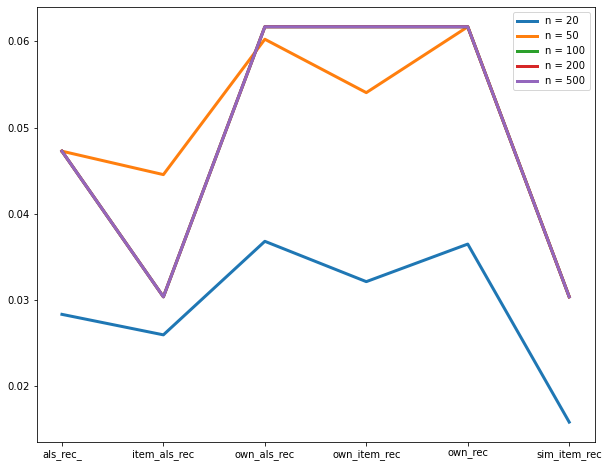

In [70]:
plt.figure(figsize=(10, 8))
for n in recall.keys():
    plt.plot([i[0] for i in recall[n]], [i[1] for i in recall[n]], label=n, linewidth=3)
plt.legend()

Заметно, что при увеличении числа кандидатов k возрастает и качество модели. Наиболее разумно взять k = 100, т.к. при больших значениях результат меняется незначительно, но генерация занимает больше времени

Наилучший результат получается при использовании методов ("own_recommendations" и "als_recommendations") или при использовании только метода "own_recommendations", в обоих случаях получаются схожие результаты

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [71]:
df_ranker_train.head(10)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
5,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
6,2070,1032703,0.0,1087,SEAFOOD-PCKGD,National,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
8,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
9,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [72]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [73]:
retail_data = pd.read_csv('retail_train.csv')

In [74]:
retail_data

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0


In [75]:
df_retail = df_ranker_train.merge(retail_data, on=[USER_COL, ITEM_COL], how='left')

In [76]:
df_retail.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.929993e+10,174.0,1.0,3.99,311.0,0.0,207.0,26.0,0.0,0.0
1,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.935274e+10,178.0,1.0,3.99,311.0,0.0,217.0,26.0,0.0,0.0
2,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.948473e+10,185.0,1.0,3.99,311.0,0.0,203.0,27.0,0.0,0.0
3,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.950715e+10,186.0,1.0,3.99,311.0,0.0,211.0,27.0,0.0,0.0
4,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,3.024106e+10,228.0,1.0,3.99,311.0,0.0,210.0,33.0,0.0,0.0


In [77]:
# средний чек пользователя
df_for_mean_sales = df_retail.groupby(USER_COL)[['sales_value', 'quantity']].sum().reset_index()
df_for_mean_sales['mean_sales'] = df_for_mean_sales['sales_value'] / df_for_mean_sales['quantity']

In [78]:
df_for_mean_sales

,user_id,sales_value,quantity,mean_sales
0,1,1393.24,463.0,3.009158
1,6,1100.45,241.0,4.566183
2,7,363.24,94.0,3.864255
3,8,394.31,96.0,4.107396
4,9,257.35,65.0,3.959231
...,...,...,...,...
1910,2496,434.32,124.0,3.502581
1911,2497,742.78,165.0,4.501697
1912,2498,337.51,89.0,3.792247
1913,2499,343.54,94.0,3.654681


In [79]:
df_for_mean_sales = df_for_mean_sales[['user_id', 'mean_sales']]
df_for_mean_sales

,user_id,mean_sales
0,1,3.009158
1,6,4.566183
2,7,3.864255
3,8,4.107396
4,9,3.959231
...,...,...
1910,2496,3.502581
1911,2497,4.501697
1912,2498,3.792247
1913,2499,3.654681


In [80]:
df_ranker_train

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99394,1745,948832,0.0,1719,MEAT-PCKGD,National,HOT DOGS,BETTER FOR YOU,1 LB,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
99395,1745,903454,0.0,1216,MEAT-PCKGD,National,FROZEN MEAT,OTHER - FULLY COOKED,32 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
99396,1745,9419888,0.0,759,GROCERY,National,YOGURT,YOGURT MULTI-PACKS,48 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
99397,1745,880469,0.0,544,GROCERY,National,BAG SNACKS,CORN CHIPS,10 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown


In [81]:
df_ranker_train = df_ranker_train.merge(df_for_mean_sales, on=[USER_COL], how='left')

In [82]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_sales
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661


In [83]:
# доля покупок для данной категории среди всех покупок пользователя
group_category = df_retail.groupby(USER_COL)[['department']].count().reset_index()
group_category.head()

,user_id,department
0,1,430
1,6,193
2,7,97
3,8,97
4,9,65


In [84]:
%%time
list_with_share_category = []
for index, row in df_ranker_train.iterrows():
    quantity_in_category = df_retail[df_retail[USER_COL] == row[USER_COL]]['department'].value_counts()[row['department']]
    quantity_all_category = group_category[group_category[USER_COL] == row[USER_COL]]['department'].values[0]
    list_with_share_category.append(quantity_in_category / quantity_all_category)

Wall time: 3min


In [85]:
df_ranker_train['share_category'] = list_with_share_category

In [86]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_sales,share_category
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.107843
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.549020
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431


In [87]:
df_retail.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.929993e+10,174.0,1.0,3.99,311.0,0.0,207.0,26.0,0.0,0.0
1,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.935274e+10,178.0,1.0,3.99,311.0,0.0,217.0,26.0,0.0,0.0
2,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.948473e+10,185.0,1.0,3.99,311.0,0.0,203.0,27.0,0.0,0.0
3,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.950715e+10,186.0,1.0,3.99,311.0,0.0,211.0,27.0,0.0,0.0
4,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,3.024106e+10,228.0,1.0,3.99,311.0,0.0,210.0,33.0,0.0,0.0


In [88]:
#цена товара
df_for_price = df_retail.groupby('item_id')[['quantity', 'sales_value']].sum().reset_index()
df_for_price['price_item'] =  df_for_price['sales_value'] / df_for_price['quantity']
df_for_price = df_for_price[['item_id', 'price_item']]
df_for_price

,item_id,price_item
0,818981,3.177222
1,819308,3.506000
2,819400,2.759091
3,819487,2.985532
4,819590,3.375556
...,...,...
4432,15778319,4.990000
4433,15831209,2.394286
4434,15831255,4.535455
4435,15926844,2.287895


In [89]:
df_ranker_train = df_ranker_train.merge(df_for_price, on=['item_id'], how='left')
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_sales,share_category,price_item
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.107843,3.961840
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.549020,11.471481
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,7.237222
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,6.596122
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,7.650973


In [90]:
# отношение цены к средней цене товара в категории 
df_avg_price = df_retail.groupby('department')[['quantity', 'sales_value']].sum().reset_index()
df_avg_price['avg_price'] = df_avg_price['sales_value'] / df_avg_price['quantity']
df_avg_price = df_avg_price[['department', 'avg_price']]
df_avg_price

,department,avg_price
0,COSMETICS,5.000000
1,DELI,3.753900
2,DRUG GM,5.118056
3,FLORAL,7.741622
4,GROCERY,3.446910
5,MEAT,4.254212
6,MEAT-PCKGD,3.560929
7,MISC. TRANS.,2.575385
8,NUTRITION,3.212456
9,PASTRY,3.186725


In [91]:
%%time
list_with_avg_price = []
for index, row in df_ranker_train.iterrows():
    price = df_for_price[df_for_price['item_id'] == row['item_id']]['price_item'].values[0]
    average_price_in_category = df_avg_price[df_avg_price['department'] == row['department']]['avg_price'].values[0]
    list_with_avg_price.append(price / average_price_in_category)

Wall time: 1min 20s


In [92]:
df_ranker_train['price_to_average'] = list_with_avg_price

In [93]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_sales,share_category,price_item,price_to_average
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.107843,3.961840,1.055393
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.549020,11.471481,3.328048
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,7.237222,1.414057
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,6.596122,1.288794
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,7.650973,1.494898


In [94]:
df_retail.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.929993e+10,174.0,1.0,3.99,311.0,0.0,207.0,26.0,0.0,0.0
1,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.935274e+10,178.0,1.0,3.99,311.0,0.0,217.0,26.0,0.0,0.0
2,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.948473e+10,185.0,1.0,3.99,311.0,0.0,203.0,27.0,0.0,0.0
3,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,2.950715e+10,186.0,1.0,3.99,311.0,0.0,211.0,27.0,0.0,0.0
4,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,3.024106e+10,228.0,1.0,3.99,311.0,0.0,210.0,33.0,0.0,0.0


In [95]:
# Среднее количество покупок всеми юзерами конкретной категории в неделю
num_week = max(df_retail['week_no'])
df_avg_for_category_on_week = df_retail.groupby('department')['quantity'].count().reset_index()
df_avg_for_category_on_week['avg_quantity_in_week'] = df_avg_for_category_on_week['quantity'].values / num_week
df_avg_for_category_on_week['avg_quantity_buy_in_week'] = df_avg_for_category_on_week['avg_quantity_in_week'].apply(lambda x: round(x))
df_avg_for_category_on_week = df_avg_for_category_on_week[['department', 'avg_quantity_buy_in_week']]
df_ranker_train = df_ranker_train.merge(df_avg_for_category_on_week, on=['department'], how='left')
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_sales,share_category,price_item,price_to_average,avg_quantity_buy_in_week
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.107843,3.961840,1.055393,184
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.549020,11.471481,3.328048,2248
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,7.237222,1.414057,344
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,6.596122,1.288794,344
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,7.650973,1.494898,344


In [96]:
# Среднее отношение покупок в категории за неделю к общему количеству покупок за неделю
df_sum_for_category_on_week = df_retail.groupby(['week_no','department'])['quantity'].count().reset_index()
df_sum_all_category_on_week = df_sum_for_category_on_week.groupby(['week_no'])['quantity'].sum().reset_index()
df_sum_for_category_on_week = df_sum_for_category_on_week.merge(df_sum_all_category_on_week, on=['week_no'], how='left')
df_sum_for_category_on_week['ratio_in_category_to_total_in_week'] = df_sum_for_category_on_week['quantity_x'] / df_sum_for_category_on_week['quantity_y']
df_sum_for_category_on_week = df_sum_for_category_on_week[['week_no', 'department', 'ratio_in_category_to_total_in_week']]
df_sum_for_category_on_week = df_sum_for_category_on_week.groupby(['department'])['ratio_in_category_to_total_in_week'].mean().reset_index()
df_sum_for_category_on_week.head()

,department,ratio_in_category_to_total_in_week
0,COSMETICS,0.000445
1,DELI,0.052741
2,DRUG GM,0.095613
3,FLORAL,0.001075
4,GROCERY,0.644194


In [97]:
df_ranker_train = df_ranker_train.merge(df_sum_for_category_on_week, on=['department'], how='left')
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_sales,share_category,price_item,price_to_average,avg_quantity_buy_in_week,ratio_in_category_to_total_in_week
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,Unknown,1,None/Unknown,3.437661,0.107843,3.961840,1.055393,184,0.052741
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,Unknown,1,None/Unknown,3.437661,0.549020,11.471481,3.328048,2248,0.644194
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,7.237222,1.414057,344,0.095613
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,6.596122,1.288794,344,0.095613
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,Unknown,Unknown,1,None/Unknown,3.437661,0.078431,7.650973,1.494898,344,0.095613


In [98]:
recommender = MainRecommender(data_train_matcher)

In [99]:
result = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result.columns=[USER_COL, ACTUAL_COL]
result.head()

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1..."


In [100]:
%%time
N_PREDICT = 50 
result['own_rec'] = result[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

Wall time: 7.04 s


In [101]:
TOPK_PRECISION = 5
sorted(calc_precision(result, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.18872062663185182)]

In [102]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [103]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'mean_sales',
 'share_category',
 'price_item',
 'price_to_average',
 'avg_quantity_buy_in_week',
 'ratio_in_category_to_total_in_week']

In [104]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [105]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [106]:
df_ranker_predict.head(10)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,hh_comp_desc,household_size_desc,kid_category_desc,mean_sales,share_category,price_item,price_to_average,avg_quantity_buy_in_week,ratio_in_category_to_total_in_week,proba_item_purchase
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,1,None/Unknown,3.437661,0.107843,3.961840,1.055393,184,0.052741,0.055237
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,1,None/Unknown,3.437661,0.549020,11.471481,3.328048,2248,0.644194,0.008977
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,Unknown,1,None/Unknown,3.437661,0.078431,7.237222,1.414057,344,0.095613,0.006238
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,Unknown,1,None/Unknown,3.437661,0.078431,6.596122,1.288794,344,0.095613,0.000773
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,Unknown,1,None/Unknown,3.437661,0.078431,7.650973,1.494898,344,0.095613,0.103839
5,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,...,Unknown,1,None/Unknown,3.437661,0.245098,3.752963,1.053928,241,0.070246,0.077797
6,2070,1032703,0.0,1087,SEAFOOD-PCKGD,National,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,...,Unknown,1,None/Unknown,3.437661,0.009804,3.164416,0.689843,31,0.008515,0.013199
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,...,Unknown,1,None/Unknown,3.437661,0.078431,34.964545,6.831606,344,0.095613,0.000914
8,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,...,Unknown,1,None/Unknown,3.437661,0.245098,2.758776,0.774735,241,0.070246,0.375025
9,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,...,Unknown,1,None/Unknown,3.437661,0.245098,2.758776,0.774735,241,0.070246,0.375025


In [107]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [108]:
result['reranked_own_rec'] = result[USER_COL].apply(lambda user_id: rerank(user_id))

In [109]:
print(*sorted(calc_precision(result, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.2812532637075694)
('own_rec', 0.18872062663185182)


Качество модели улучшилось при добавлении новых признаков и при использовании двухуровневой модели